In [45]:
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
import os.path as osp
import networkx as nx
import numpy as np

In [77]:
gr = nx.erdos_renyi_graph(5, 0.5)
gr.nodes()[0]['atomic_num'] = 1
gr.nodes()[0]['is_aromatic'] = 1

gr.nodes()[1]['atomic_num'] = 2
gr.nodes()[1]['is_aromatic'] = 0

gr.nodes()[2]['atomic_num'] = 12
gr.nodes()[2]['is_aromatic'] = 0

gr.nodes()[3]['atomic_num'] = 1
gr.nodes()[3]['is_aromatic'] = 1

gr.nodes()[4]['atomic_num'] = 5
gr.nodes()[4]['is_aromatic'] = 0

gr_list = [gr]

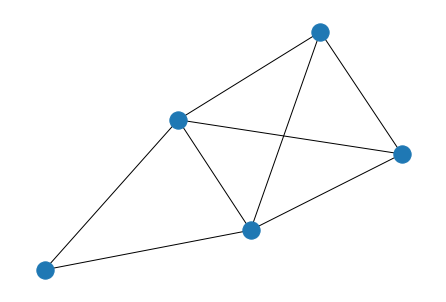

In [81]:
nx.draw(gr)

In [92]:
# *****how are graph labels being sent across? 
num_features = 2
def nx_to_pyg(graph_list):
    data_list = []
    for gr in graph_list:
        x = np.zeros((len(gr.nodes()),num_features))
        i = 0
        for v in gr.nodes().data():
            x[i,0] = v[1]['atomic_num']
            x[i,1] = v[1]['is_aromatic']
            i += 1
        x = torch.Tensor(x)
        
        edge_index = []
        for e in gr.edges().data():
            edge_index.append([e[0], e[1]])
        edge_index = torch.Tensor(edge_index).t().contiguous()
        
        
        data_list.append(Data(x=x, edge_index=edge_index))
    
    return data_list

In [91]:
nx_to_pyg(gr_list)

[Data(x=[5, 2], edge_index=[2, 8])]

In [100]:
class B3DB_4pyg(InMemoryDataset):
    
    def __init__(self, root='tmp/B3DB_4pyg',
                 transform=None, pre_transform=None, pre_filter=None):
        super(B3DB_4pyg, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])        
    
    @property
    def raw_file_names(self):
        return ['raw_file_name.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']
    
    def process(self):
        self.RAW_DATA_DIR = 'data-path/'
        data_list = torch.load(self.RAW_DATA_DIR+self.raw_file_names[0])
                
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        print(self.processed_paths[0])
        


In [101]:
dataset = B3DB_4pyg()

Processing...


FileNotFoundError: [Errno 2] No such file or directory: 'data-path/raw_file_name.pt'